In [20]:
import os
import random
import soundfile as sf
import torch
import yaml
import json
import argparse
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from pathlib import Path

from asteroid.metrics import get_metrics
from asteroid.utils import tensors_to_device
from asteroid.dsp.normalization import normalize_estimates
from asteroid.metrics import get_metrics

import matplotlib.pyplot as plt 
import numpy as np

import sys 
sys.path.append("/data1/wangyiwen/repos/graduateproject/speakerbeam/src/")


from models.td_speakerbeam import TimeDomainSpeakerBeam

In [16]:
ckpt_pth = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix/exp/casual_enroll_only_chunkwise_cgLN/best_model.pth"
model = TimeDomainSpeakerBeam(i_adapt_layer=7, adapt_layer_type='mul', adapt_enroll_dim=128, causal=True).from_pretrained(ckpt_pth)
use_cuda = True 
if use_cuda:
    model.cuda()

In [75]:
import scipy.io as io 
from IPython.display import Audio, display
import glob 
import librosa
import pandas as pd 

COMPUTE_METRICS = ["si_sdr", "sdr", "sir", "sar", "stoi"]

# mix_wavpath = "/data2/wangyiwen/dataset/librimix/Libri2Mix/wav8k/min/dev/mix_clean/2412-153948-0002_7850-111771-0009.wav"
mix_wavpath = "/data2/wangyiwen/dataset/librimix/Libri2Mix/wav8k/min/dev/mix_clean/1272-141231-0022_84-121123-0002.wav"
# mix_wavpath = "/data2/wangyiwen/dataset/librimix/Libri2Mix/wav8k/min/dev/mix_clean/3536-23268-0010_1919-142785-0009.wav"
mix_wav, mix_sr = sf.read(mix_wavpath)
src_wavpath = mix_wavpath.replace("mix_clean", "s1")
source_wav, source_sr = sf.read(src_wavpath)
if use_cuda:
    mix = torch.from_numpy(mix_wav).float().cuda()
    source = torch.from_numpy(source_wav).float().cuda()
else:
    mix = torch.from_numpy(mix_wav).float()
    source = torch.from_numpy(source_wav).float()
# print(mix_sr, mix_wav.shape)
display(Audio(mix_wav, rate=mix_sr))
display(Audio(source_wav, rate=source_sr))
enroll_id = mix_wavpath.split("/")[-1].split("-")[0]
enroll_paths = glob.glob(f"/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/{enroll_id}/*/*.flac")
print("enroll num: ", len(enroll_paths))
series_list = []
for enroll_path in enroll_paths:
    enroll_wav, enroll_sr = sf.read(enroll_path)
    # print(enroll_path, enroll_sr, enroll_wav.shape)
    resample_enroll_wav = librosa.resample(enroll_wav, orig_sr=enroll_sr, target_sr=mix_sr)
    # display(Audio(resample_enroll_wav, rate=mix_sr))
    enroll = torch.from_numpy(resample_enroll_wav).float()
    if use_cuda:
        enroll = enroll.cuda()
    est_source = model(mix.unsqueeze(0), enroll.unsqueeze(0))
    # display(Audio(est_source.squeeze(0).cpu().data.numpy(), rate=mix_sr))
    # print("est source shape: ", est_source.shape)
    mix_np = mix.cpu().data.numpy()
    source_np = source.cpu().data.numpy()
    est_source_np = est_source.squeeze(0).cpu().data.numpy()
    utt_metrics = get_metrics(
        mix_np,
        source_np,
        est_source_np,
        sample_rate=8000,
        metrics_list=COMPUTE_METRICS,
    )
    series_list.append(pd.Series(utt_metrics))
    # break
all_metrics_df = pd.DataFrame(series_list)
sort_si_sdr_args = np.argsort(all_metrics_df['si_sdr'])[::-1]
sort_stoi_args = np.argsort(all_metrics_df['stoi'])[::-1]

enroll num:  73


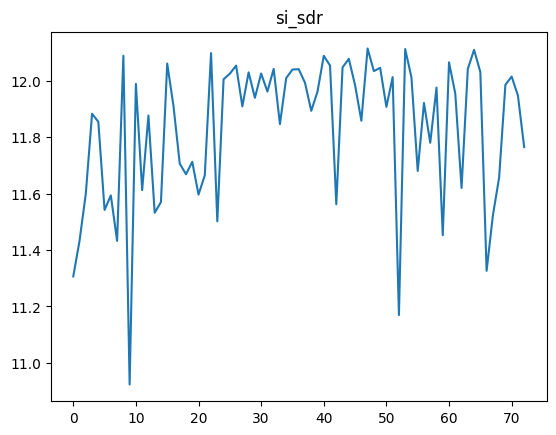

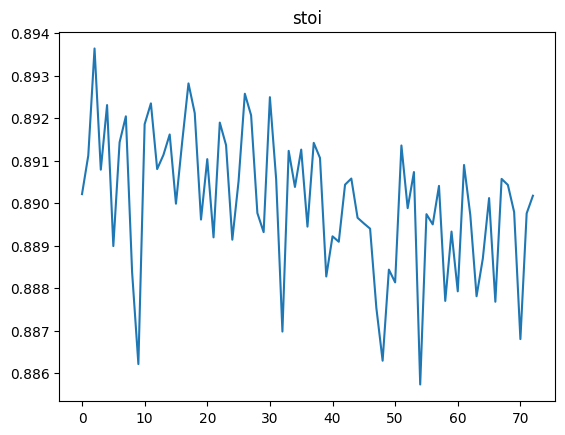

In [76]:
import matplotlib.pyplot as plt

plt.plot(all_metrics_df['si_sdr'])
plt.title("si_sdr")
plt.show()
plt.plot(all_metrics_df['stoi'])
plt.title("stoi")
plt.show()

In [77]:
enroll_paths_np = np.array(enroll_paths)
enroll_path_select_sdr = enroll_paths_np[sort_si_sdr_args[:10]]
print(enroll_path_select_sdr)
# enroll_path_select_sdr = enroll_paths_np[sort_si_sdr_args[-10:]]
# print(enroll_path_select_sdr)
# enroll_path_select_stoi = enroll_paths_np[sort_stoi_args[:10]]
# print(enroll_path_select_stoi)

['/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0026.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0008.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0007.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/135031/1272-135031-0000.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/135031/1272-135031-0001.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0032.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0019.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0027.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/135031/1272-135031-0003.flac'
 '/data2/wangyiwen/dataset/librimix/LibriSpeech/dev-clean/1272/141231/1272-141231-0010.flac']


In [67]:
all_metrics_df['si_sdr'][sort_si_sdr_args[:10]]

50    9.072641
48    8.994703
32    8.977123
58    8.959593
42    8.959023
63    8.956837
43    8.924174
49    8.912192
41    8.904614
60    8.894542
Name: si_sdr, dtype: float64

In [57]:
display(Audio(est_source.squeeze(0).cpu().data.numpy(), rate=mix_sr))